### Image classification, conceptual idea for possible mobile application in COBB County.
Train some images to classify Litter, Overgrown grass and Illegal signs as these are the main categories of Keep Cobb Beautiful project every year. More categories are possilbe if we collect more pictures. Final model can be exported to a Nerual network model of mobilnet.v2 for a mobile device application so citizen can use mobile device camera to take and save a picture. The app will automatically give the classification and submit a report to County department.

TensorFlow Lite is a lightweight solution to this problem. It reduces the overall compute requirement and size of the model making it easy to ship on mobile devices. It also supports hardware acceleration that inturn enables low-latency inferencing on mobile devices, which allows us to build real-time applications on top of it. Learn more about TensorFlow Lite here

In [1]:
import os
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker.image_classifier import ModelSpec

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
image_path=r'C:\Users\zhangc\.keras\datasets'
image_path = os.path.join(image_path, 'keepCobbbeatiful')
print (image_path)

C:\Users\zhangc\.keras\datasets\keepCobbbeatiful


In [12]:
data = DataLoader.from_folder(image_path)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

INFO:tensorflow:Load image with size: 53, num_label: 3, labels: Illegalsign, Litter, Overgrown.


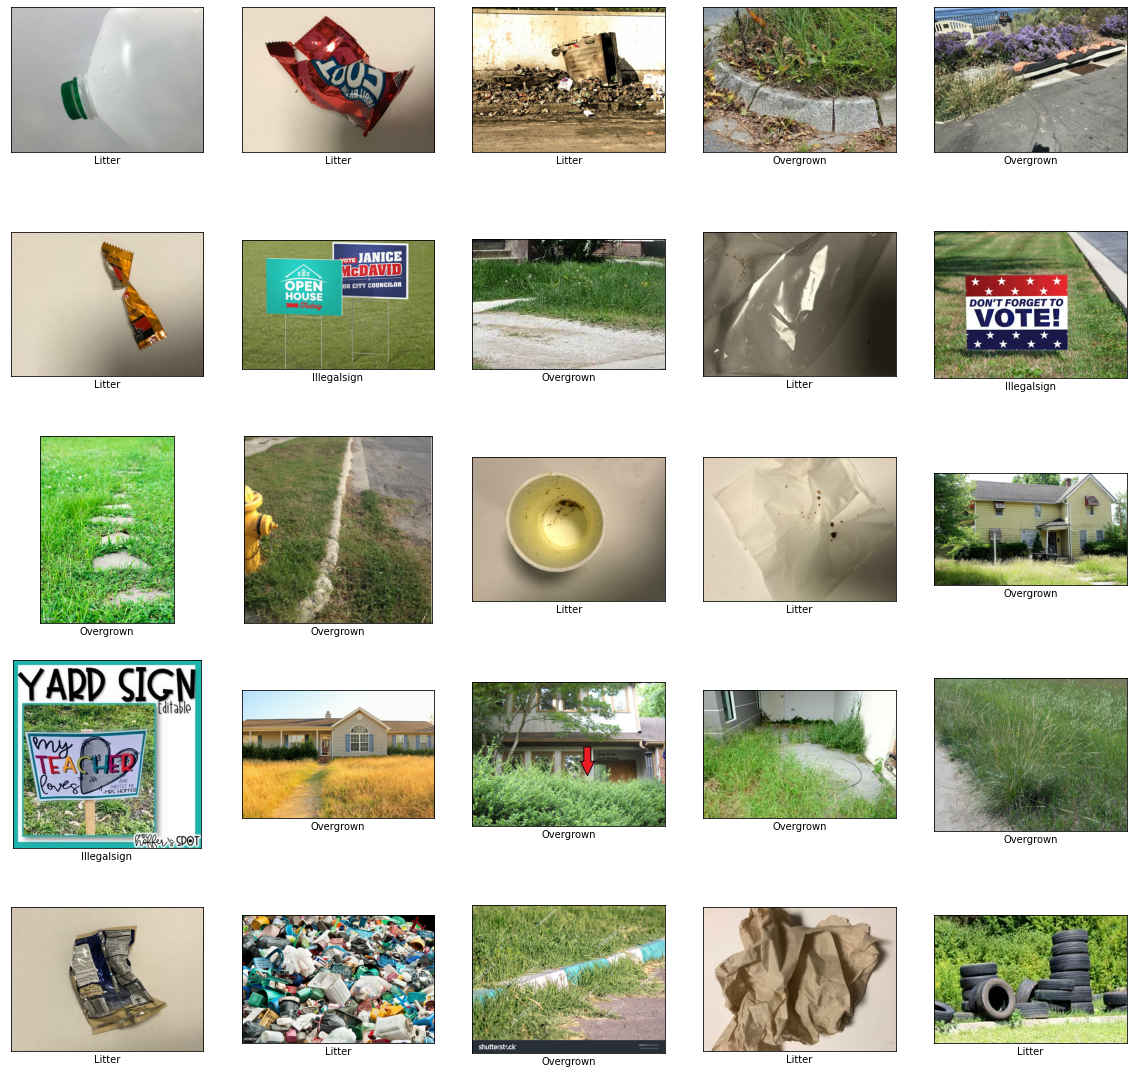

In [13]:
%matplotlib inline
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [15]:
model = image_classifier.create(train_data, validation_data=validation_data,epochs=10)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_1 (HubK (None, 1280)              3413024   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.4078 - accuracy: 0.2188
Epoch 2/10
1/1 [==============================] - 1s 544ms/step - loss: 1.3650 - accuracy: 0.3125
Epoch 3/10
1/1 [==============================] - 1s 543ms/step - loss: 1.2075 - accuracy: 0.3438
Epoch 4/10
1/1 [==============================] - 1s 539ms/step - loss: 1.

In [16]:
loss, accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 583ms/step - loss: 0.5242 - accuracy: 0.8333


### Let's view some predictions

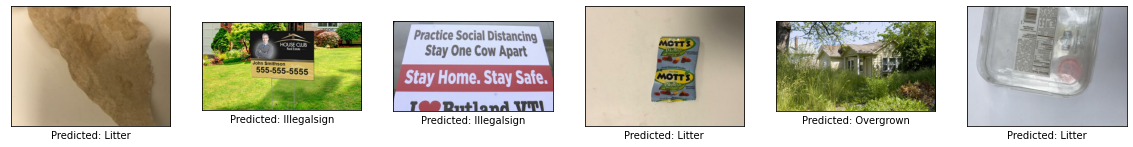

In [26]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 6 test images which are not used in training and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(36)):
  ax = plt.subplot(6, 6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [ ]:
model.export(export_dir='.', with_metadata=False)

### Change the model
Change to the model that's supported in this library.
This library supports EfficientNet-Lite models, MobileNetV2, ResNet50 by now. EfficientNet-Lite are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

We could switch model to MobileNetV2 by just setting parameter model_spec to the MobileNetV2 model specification in create method.

In [21]:
model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data,epochs=10)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_3 (HubK (None, 1280)              2257984   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.2898 - accuracy: 0.3438
Epoch 2/10
1/1 [==============================] - 1s 551ms/step - loss: 1.2271 - accuracy: 0.4688
Epoch 3/10
1/1 [==============================] - 1s 502ms/step - loss: 1.0262 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 494ms/step - loss: 0.

In [22]:
loss, accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 644ms/step - loss: 0.5351 - accuracy: 1.0000


### Post-training quantization on the TensorFLow Lite model
Post-training quantization is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator latency, with little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker supports multiple post-training quantization options. Let's take full integer quantization as an instance. First, define the quantization config to enforce full integer quantization for all ops including the input and output. The input type and output type are uint8 by default. You may also change them to other types like int8 by setting inference_input_type and inference_output_type in config.

In [ ]:
config = QuantizationConfig.for_int8(representative_data=test_data)

In [25]:
model.export(export_dir='.', tflite_filename='model_quant.tflite', quantization_config=config,with_metadata=False)

INFO:tensorflow:Assets written to: C:\Users\zhangc\AppData\Local\Temp\tmpimane4ne\assets


INFO:tensorflow:Assets written to: C:\Users\zhangc\AppData\Local\Temp\tmpimane4ne\assets


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model_quant.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: .\model_quant.tflite


INFO:tensorflow:Saving labels in .\labels.txt.


INFO:tensorflow:Saving labels in .\labels.txt.
